In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError,RootMeanSquaredError


from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [16]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [17]:
print(tf.__version__)

2.12.0


In [18]:
tf.random.set_seed(42)
np.random.seed(42)

In [19]:
drop_list=["Open","High","Low","Close","Volume"]
# drop_list=[]
train_df = pd.read_csv('data/train.csv').drop(drop_list,axis=1)
val_df = pd.read_csv('data/val.csv').drop(drop_list,axis=1)
test_df = pd.read_csv('data/test.csv').drop(drop_list,axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(1442, 11) (412, 11) (179, 11)


In [20]:
timestamp_s = pd.to_datetime(train_df['Date']).map(datetime.datetime.timestamp)
train_df['Coin_timestamp'] = timestamp_s
train_df = train_df.drop(['Date'], axis=1)

timestamp_s = pd.to_datetime(val_df['Date']).map(datetime.datetime.timestamp)
val_df['Coin_timestamp'] = timestamp_s
val_df = val_df.drop(['Date'], axis=1)

timestamp_s = pd.to_datetime(test_df['Date']).map(datetime.datetime.timestamp)
test_df['Coin_timestamp'] = timestamp_s
test_df = test_df.drop(['Date'], axis=1)

In [21]:
train_df

,Adj Close,SMA_7,SMA_14,EMA_7,EMA_14,RSI,Stoch_RSI,Upper_BB,Lower_BB,MACD,Coin_timestamp
0,428.588013,457.861293,457.749433,452.774001,443.875941,59.208403,0.000000,529.892890,325.173818,30.081025,1.512490e+09
1,434.407990,456.046147,459.481005,448.181404,442.593327,55.123209,0.000000,524.679154,340.588952,26.933777,1.512576e+09
2,456.031006,454.544861,458.132433,450.144155,444.409837,45.120639,0.000000,521.373494,354.736512,25.885959,1.512662e+09
3,473.502014,455.981005,458.648577,455.984402,448.335278,51.785929,0.150088,518.732628,369.288981,26.163721,1.512749e+09
4,441.721008,452.533578,456.533650,452.418195,447.444231,43.536034,0.000000,513.089733,382.430976,23.547942,1.512835e+09
...,...,...,...,...,...,...,...,...,...,...,...
1437,4667.115234,4674.709403,4562.634103,4655.170472,4549.006055,60.292536,0.000000,4928.663302,3965.944925,229.651464,1.636646e+09
1438,4651.460449,4693.263602,4585.906250,4654.242966,4562.666641,64.134466,0.308957,4933.679259,4017.284706,218.189659,1.636733e+09
1439,4626.358887,4694.092773,4610.069441,4647.271946,4571.158940,64.836227,0.365391,4942.011601,4049.800557,204.720717,1.636819e+09
1440,4557.503906,4657.723703,4626.703509,4624.829936,4569.338269,59.931928,0.000000,4929.388514,4105.063829,186.342423,1.636906e+09


## `DataWindow` class 

In [22]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [23]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[RootMeanSquaredError()])
        # RootMeanSquaredError
        # MeanAbsoluteError
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [24]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [25]:
multi_window = DataWindow(input_width=7, label_width=7, shift=1,label_columns=['Adj Close'])

In [26]:
Train_performance = {}
Test_performance = {}

## LSTM model 

In [27]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

Epoch 1/1000
45/45 [==============================] - 2s 12ms/step - loss: 1782695.5000 - root_mean_squared_error: 1335.1763 - val_loss: 5803320.5000 - val_root_mean_squared_error: 2409.0083
Epoch 2/1000
45/45 [==============================] - 0s 5ms/step - loss: 1781998.7500 - root_mean_squared_error: 1334.9152 - val_loss: 5801468.0000 - val_root_mean_squared_error: 2408.6238
Epoch 3/1000
45/45 [==============================] - 0s 5ms/step - loss: 1781301.5000 - root_mean_squared_error: 1334.6542 - val_loss: 5799629.0000 - val_root_mean_squared_error: 2408.2419
Epoch 4/1000
45/45 [==============================] - 0s 5ms/step - loss: 1780605.0000 - root_mean_squared_error: 1334.3932 - val_loss: 5797778.0000 - val_root_mean_squared_error: 2407.8577
Epoch 5/1000
45/45 [==============================] - 0s 5ms/step - loss: 1779911.2500 - root_mean_squared_error: 1334.1329 - val_loss: 5795885.5000 - val_root_mean_squared_error: 2407.4644
Epoch 6/1000
45/45 [=============================

In [28]:
Train_performance['LSTM'] = lstm_model.evaluate(multi_window.train, verbose=0)
Test_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)
print(Train_performance)
print(Test_performance)

{'LSTM': [1275746.875, 1129.48974609375]}
{'LSTM': [1800205.25, 1341.71728515625]}


## CNN model 

In [44]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [45]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)



Train_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.train, verbose=0)
Test_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 1s 4ms/step - loss: 137389645234176.0000 - mean_absolute_error: 5834866.0000 - val_loss: 3748290363392.0000 - val_mean_absolute_error: 1807745.0000
Epoch 2/1000
45/45 [==============================] - 0s 2ms/step - loss: 658143641600.0000 - mean_absolute_error: 461052.2188 - val_loss: 30582605824.0000 - val_mean_absolute_error: 128480.7109
Epoch 3/1000
45/45 [==============================] - 0s 2ms/step - loss: 11124718592.0000 - mean_absolute_error: 52989.8125 - val_loss: 13794253824.0000 - val_mean_absolute_error: 44962.7461
Epoch 4/1000
45/45 [==============================] - 0s 3ms/step - loss: 2673118976.0000 - mean_absolute_error: 15194.3936 - val_loss: 8378220544.0000 - val_mean_absolute_error: 30497.1523
Epoch 5/1000
45/45 [==============================] - 0s 2ms/step - loss: 1745463296.0000 - mean_absolute_error: 10981.9951 - val_loss: 6089675264.0000 - val_mean_absolute_error: 25333.3203
Epoch 6/1000
45/45 [===========

## CNN + LSTM model 

In [46]:
cnn_lstm_model = Sequential([
    Conv1D(50, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(50, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

Train_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.train, verbose=0)
Test_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 2s 12ms/step - loss: 1790233.8750 - mean_absolute_error: 827.6487 - val_loss: 5555531.5000 - val_mean_absolute_error: 2161.6467
Epoch 2/1000
45/45 [==============================] - 0s 5ms/step - loss: 1789387.3750 - mean_absolute_error: 827.1409 - val_loss: 5553368.5000 - val_mean_absolute_error: 2161.1453
Epoch 3/1000
45/45 [==============================] - 0s 5ms/step - loss: 1788539.3750 - mean_absolute_error: 826.6246 - val_loss: 5551168.0000 - val_mean_absolute_error: 2160.6350
Epoch 4/1000
45/45 [==============================] - 0s 6ms/step - loss: 1787688.1250 - mean_absolute_error: 826.1091 - val_loss: 5548994.0000 - val_mean_absolute_error: 2160.1304
Epoch 5/1000
45/45 [==============================] - 0s 6ms/step - loss: 1786841.6250 - mean_absolute_error: 825.5925 - val_loss: 5546811.5000 - val_mean_absolute_error: 2159.6240
Epoch 6/1000
45/45 [==============================] - 0s 6ms/step - loss: 1785988.8750 - mean_

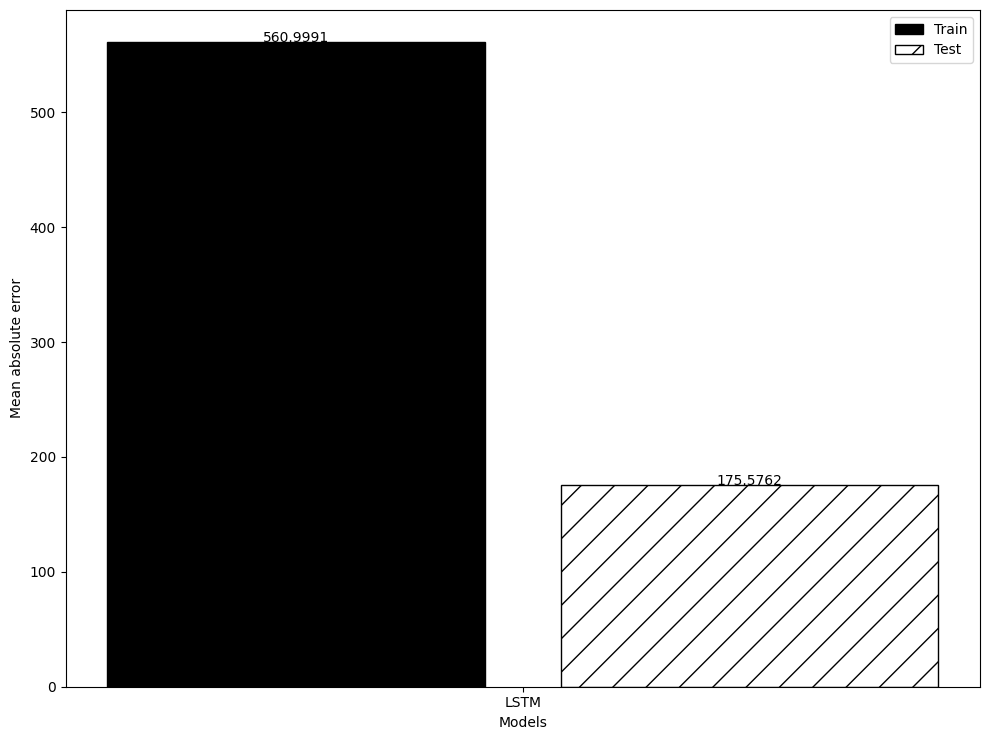

In [70]:
mae_Train = [v[1] for v in Train_performance.values()]
mae_test = [v[1] for v in Test_performance.values()]

x = np.arange(len(Test_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_Train, width=0.25, color='black', edgecolor='black', label='Train')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_Train):
    plt.text(x=index - 0.15, y=value, s=str(round(value, 4)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value, s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=Test_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)